In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
!pip show keras

Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: keras-tuner, tensorflow


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Activation, Dense, Dropout, Input, Embedding, Reshape
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
%matplotlib inline

In [5]:
# Load the data
# تحميل البيانات
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', delimiter=',', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# Check if the columns 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' exist before dropping them
# التحقق من وجود الأعمدة 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' قبل حذفها

columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

# Check if these columns are in the DataFrame
# التحقق إذا كانت هذه الأعمدة موجودة في الـ DataFrame
existing_columns = [col for col in columns_to_drop if col in data.columns]

# Drop only the existing columns
# حذف الأعمدة الموجودة فقط
if existing_columns:
    data.drop(existing_columns, axis=1, inplace=True)
    print(f"Dropped columns: {existing_columns}")
else:
    print("No columns to drop.")

Dropped columns: ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


In [7]:
# Display information about the DataFrame
# عرض معلومات عن الـ DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Select the 'v2' column as features (X) and 'v1' column as labels (Y)
# اختيار عمود 'v2' كميزات (X) وعمود 'v1' كتصنيفات (Y)
X = data.v2  # 'v2' contains the message texts
Y = data.v1  # 'v1' contains the labels (spam or ham)

In [10]:
# Initialize a label encoder
# تهيئة مُرمز التصنيفات
le = LabelEncoder()

In [11]:
# Apply the encoder to transform 'spam'/'ham' labels into numeric values (0 and 1)
# تطبيق المُرمز لتحويل تصنيفات 'spam'/'ham' إلى قيم رقمية (0 و 1)
Y = le.fit_transform(Y)  # 'spam' will be transformed to 1, 'ham' to 0

In [12]:
# Reshape Y to be a column matrix (required for training)
# تغيير شكل Y ليصبح مصفوفة عمودية (مطلوب للتدريب)
Y = Y.reshape(-1, 1)  # Transform Y from shape (n,) to (n, 1), where n is the number of samples

In [13]:
# Split the data into training and testing sets
# تقسيم البيانات إلى مجموعة تدريب واختبار
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

In [14]:
# Text preprocessing: Remove stop words, lowercase, and tokenize the text
# معالجة النصوص: إزالة الكلمات الشائعة، تحويل النص إلى أحرف صغيرة، وتجزئة النص
tfidf = TfidfVectorizer(stop_words='english', max_features=2500)  # TF-IDF vectorizer to capture important words

In [15]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [16]:
# Convert the sparse matrix to a dense matrix (required for input into neural networks)
# تحويل المصفوفة النادرة إلى مصفوفة كثيفة (مطلوبة كمدخلات للشبكات العصبية)
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [17]:
# Reshape Y to be a column matrix (required for training)
# تغيير شكل Y ليصبح مصفوفة عمودية (مطلوب للتدريب)
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

In [18]:
# Define the maximum number of words and the maximum sequence length
# تحديد العدد الأقصى للكلمات وطول التسلسل الأقصى
max_words = 2500   # You can change this based on your dataset
max_len = 150      # Length of each sequence

In [19]:
def RNN():
    # Initialize a sequential model
    # تهيئة نموذج تسلسلي
    model = Sequential()

    # Add the input layer as the first layer
    # إضافة طبقة الإدخال كأول طبقة
    model.add(Embedding(max_words, 50, input_length=max_len))  # Input shape is implicitly set

    # Apply a GRU layer (you can keep GRU or change to LSTM if needed)
    # تطبيق طبقة GRU (يمكنك الإبقاء على GRU أو تغييرها إلى LSTM إذا لزم الأمر)
    model.add(GRU(64, return_sequences=True))  # return_sequences=True ensures that output is 3D

    # Now, we can safely apply the LSTM layer since the output of GRU is 3D
    # الآن يمكننا تطبيق طبقة LSTM بأمان لأن مخرج GRU هو 3D
    model.add(LSTM(64))  # Add LSTM layer to capture more complex sequences

    # Apply a fully connected dense layer with 256 neurons
    # تطبيق طبقة كثيفة متصلة بالكامل مع 256 خلية عصبية
    model.add(Dense(256, name='FC1'))

    # Apply ReLU activation
    # تطبيق تفعيل ReLU
    model.add(Activation('relu'))

    # Apply dropout to reduce overfitting
    # تطبيق Dropout لتقليل الإفراط في التكيف
    model.add(Dropout(0.5))

    # Apply the output layer (binary classification: spam or ham)
    # تطبيق طبقة الإخراج (تصنيف ثنائي: سبام أو هام)
    model.add(Dense(1, name='out_layer'))

    return model

In [20]:
# Create the model
# إنشاء النموذج
model = RNN()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Compile the model
# تجميع النموذج
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [22]:
# Display the model summary
# عرض ملخص النموذج
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Using early stopping to prevent overfitting (if validation loss does not decrease)
# استخدام الـ Early Stopping لمنع الإفراط في التكيف (إذا لم يقلل الخسارة على التحقق)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)

In [24]:
# Train the model with more epochs
# تدريب النموذج مع عدد أكبر من العصور
model.fit(X_train_tfidf, Y_train, batch_size=128, epochs=50,
          validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.8703 - loss: 0.4790 - val_accuracy: 0.8618 - val_loss: 0.4016
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.8746 - loss: 0.3814 - val_accuracy: 0.8618 - val_loss: 0.4018
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.8655 - loss: 0.3977 - val_accuracy: 0.8618 - val_loss: 0.4017
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.8617 - loss: 0.4057 - val_accuracy: 0.8618 - val_loss: 0.4023


In [25]:
# Evaluate the model on the test set
# تقييم النموذج على مجموعة الاختبار
score = model.evaluate(X_test_tfidf, Y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8777 - loss: 0.3716


In [26]:
# Print loss and accuracy
# طباعة الخسارة والدقة
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(score[0], score[1]))

Test set
  Loss: 0.399
  Accuracy: 0.864


In [27]:
# Predict the labels for the test set
# التنبؤ بالتصنيفات لمجموعة الاختبار
Y_pred = model.predict(X_test_tfidf)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


In [28]:
# Convert predictions to binary (0 or 1)
# تحويل التنبؤات إلى ثنائي (0 أو 1)
Y_pred = (Y_pred > 0.5)

In [29]:
# Print classification report (precision, recall, F1-score)
# طباعة تقرير التصنيف (الدقة، الاسترجاع، درجة F1)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       722
           1       0.00      0.00      0.00       114

    accuracy                           0.86       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.75      0.86      0.80       836



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Print confusion matrix
# طباعة مصفوفة الارتباك
conf_matrix = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix:\n', conf_matrix)

Confusion Matrix:
 [[722   0]
 [114   0]]


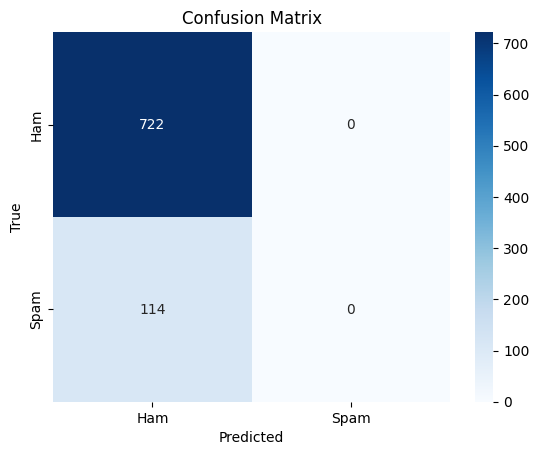

In [31]:
# Visualizing the confusion matrix
# تصور مصفوفة الارتباك
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


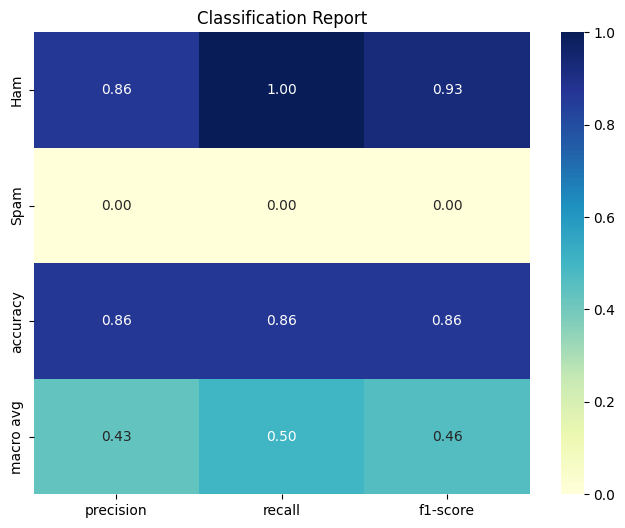

In [32]:
# Generate classification report as a dictionary
# إنشاء تقرير التصنيف كقاموس
report = classification_report(Y_test, Y_pred, target_names=['Ham', 'Spam'], output_dict=True)

# Convert the classification report to a DataFrame
# تحويل تقرير التصنيف إلى DataFrame
report_df = pd.DataFrame(report).transpose()

# Visualize the classification report as a heatmap
# تصور تقرير التصنيف باستخدام Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report')  # عنوان التقرير
plt.show()

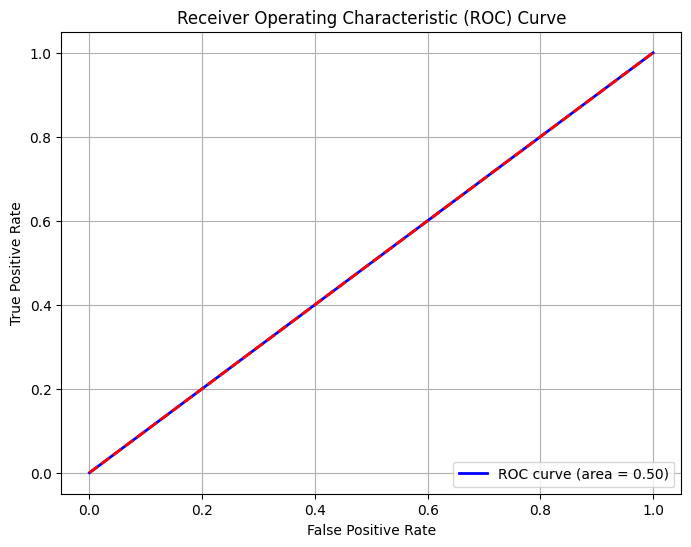

In [33]:
# Calculate the ROC curve
# حساب منحنى الـ ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
# رسم منحنى الـ ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # عرض المساحة تحت المنحنى
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # الخط العشوائي
plt.xlabel('False Positive Rate')  # معدل الإيجابيات الخاطئة
plt.ylabel('True Positive Rate')   # معدل الإيجابيات الصحيحة
plt.title('Receiver Operating Characteristic (ROC) Curve')  # عنوان الرسم
plt.legend(loc='lower right')  # مكان وسوم الرسم
plt.grid()  # إضافة شبكة
plt.show()

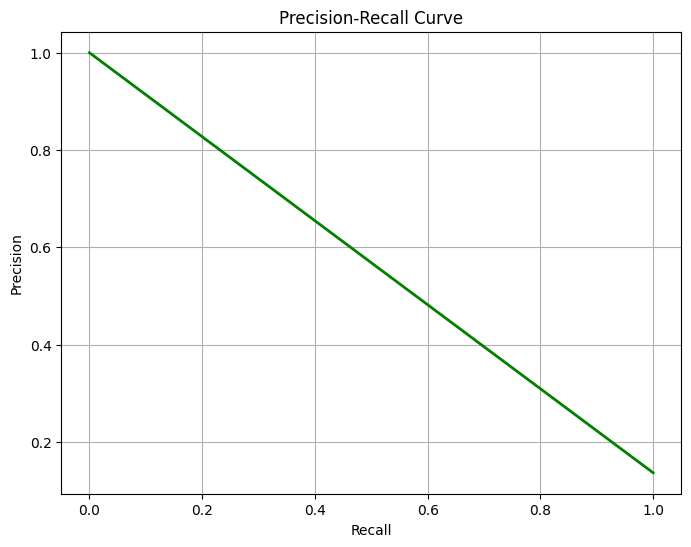

In [34]:
# Calculate precision and recall
# حساب الدقة والاسترجاع
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Plot the Precision-Recall curve
# رسم منحنى الدقة - الاسترجاع
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')  # الاسترجاع
plt.ylabel('Precision')  # الدقة
plt.title('Precision-Recall Curve')  # عنوان الرسم
plt.grid()  # إضافة شبكة
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_k

Text(0, 0.5, 'Frequency')

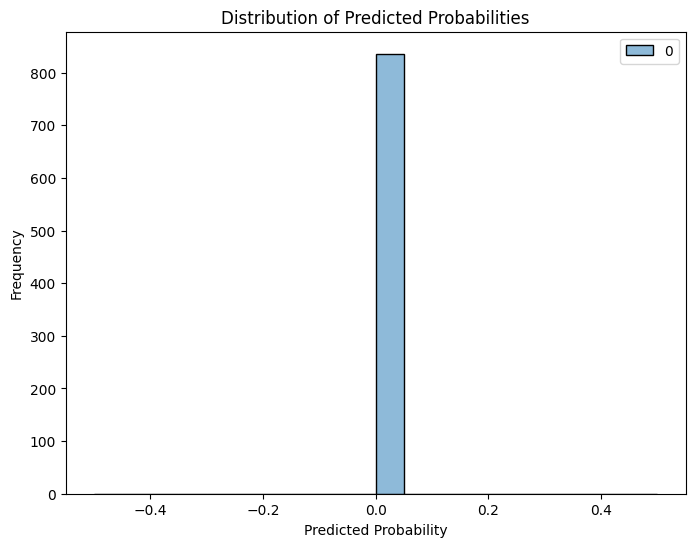

In [35]:
# Visualize the distribution of prediction probabilities
# تصور توزيع احتمالات التنبؤ

plt.figure(figsize=(8, 6))

# Ensure Y_pred is probabilities; otherwise, use model.predict(X_test) instead of Y_pred
# تأكد من أن Y_pred هي احتمالات؛ إذا لم تكن كذلك، استخدم model.predict(X_test) بدلاً من Y_pred
sns.histplot(Y_pred, bins=20, color='purple', kde=False)  # kde=False to disable Kernel Density Estimation

# Add labels and title to the plot
# إضافة التسميات والعنوان إلى الرسم
plt.title('Distribution of Predicted Probabilities')  # عنوان الرسم
plt.xlabel('Predicted Probability')  # احتمالية التنبؤ
plt.ylabel('Frequency')  # التكرار